<a href="https://colab.research.google.com/github/jshin13/MindX_time-series_analysis/blob/temp/MindX_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import zipfile
import urllib.request
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dirpath = '/content/drive/MyDrive/MindX_Data/Optical Imaging System Data Sets/'
dirpath2 = '/content/drive/MyDrive/MindX_Data/dat/'
dirpathimg = '/content/drive/MyDrive/MindX_Data/img/'
dataset = 1
# [S1, S1, S3, S2, S2]
fpath = ['offaxis_10_27_2020/tf', 'offaxis_s1_11_30_2020/tf', 
         'offaxis_s3_11_30_2020/tf', 'offaxis_11_12_2020/tf',
         'onaxis_11_18_2020/tf'][dataset]

##### GLOBAL #####
trim = 1500
BIN_NUM = 10

In [3]:
import tensorflow as tf
from pathlib import Path

def load_dataset(path):
    return (tf.data.Dataset.list_files(str(Path(path) / '*'), shuffle=False)
        # Note: cycle_length=1 ensures that sessions are loaded sequentially.
        # If sessions can be intermingled, then cycle_length can be increased for better performance.
        .interleave(_load_session, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE)
    )

@tf.function
def _load_session(path):
    name = tf.strings.split(tf.strings.split(path, '/')[-1], '\\')[-1]

    @tf.function
    def _label(data):
        out = dict(data)
        out['dataset'] = name
        return out

    ds = tf.data.experimental.load(
        path,
        dict(
            data=tf.TensorSpec((None, None), dtype=tf.float32),
            time=tf.TensorSpec((), dtype=tf.float64),
            stimulus=tf.TensorSpec((), dtype=tf.bool),
            ekg=tf.TensorSpec((), dtype=tf.float32),
            ppg=tf.TensorSpec((), dtype=tf.float32),
        ),
    )
    return ds.map(_label, num_parallel_calls=tf.data.AUTOTUNE)

ds = load_dataset(dirpath + fpath)
ds

<ParallelInterleaveDataset shapes: {data: (None, None), time: (), stimulus: (), ekg: (), ppg: (), dataset: ()}, types: {data: tf.float32, time: tf.float64, stimulus: tf.bool, ekg: tf.float32, ppg: tf.float32, dataset: tf.string}>

In [4]:
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('Agg')
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from scipy import signal
# from IPython.display import clear_output
import pickle
import gc
import seaborn as sns

In [5]:
from zipfile import ZipFile

if os.path.exists('hyppo-master'):
    print('HYPPO ALREADY INSTALLED')
else:
    try:
        with ZipFile(dirpath2 + 'hyppo-master.zip', 'r') as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall()

        # % git clone https://github.com/neurodata/hyppo
        %cd hyppo-master
        %pip install .
        %cd ..
    except:
        print('ZIP FILE DOES NOT EXIST')

HYPPO ALREADY INSTALLED


In [6]:
# %pip install hyppo # does not have KMERF yet
import hyppo

In [7]:
def compute_ROI(ds1):

    origin = [0.5, 0.5]
    radius = 0.3
    holograms = tf.convert_to_tensor(ds1, tf.float32)
    shape = [64, 64]#tf.shape(holograms)[1:]

    x, y = tf.meshgrid(
        tf.linspace(0. - origin[0], 1. - origin[0], shape[0]),
        tf.linspace(0. - origin[1], 1. - origin[1], shape[1]),
    )
    grid = tf.sqrt(x**2 + y**2)
    mask = grid <= radius

    region = tf.boolean_mask(holograms, mask, axis=0)
    mean = tf.math.reduce_mean(region, axis=-1)

    return mean, mask

In [8]:
filename = ['ds_1027_s1.pickle', 'ds_1130_s1.pickle', 'ds_1130_s3.pickle', 'ds_1112_s2.pickle', 'ds_1118_s2.pickle']
filename = dirpath2 + filename[dataset]

if os.path.exists(filename):
    with open(filename, 'rb') as f:
        ds1 = pickle.load(f, encoding='bytes')
else:
    ds1 = [[],[],[],[],[],[],[]]

    for idx, data in enumerate(tqdm(ds)):
        # if data['dataset'] == bytes(b'AQ'):
        temp = data['data'].numpy()
        # ds1[0].append(temp)
        ds1[1].append(data['time'].numpy())
        ds1[2].append(data['stimulus'].numpy())
        ds1[3].append(data['dataset'].numpy())
        ds1[4].append(data['ekg'].numpy())
        ds1[5].append(data['ppg'].numpy())
        roi, _ = compute_ROI(temp) # compute ROI for all range
        ds1[6].append(roi.numpy())

    with open(filename, 'wb') as f:
        pickle.dump(ds1, f)

data structure = [data, time, stimulus, dataset, ekg, ppg]

In [10]:
for data in ds:
    mean, mask = compute_ROI(data['data'].numpy())
    sample_data = data['data'].numpy()
    break

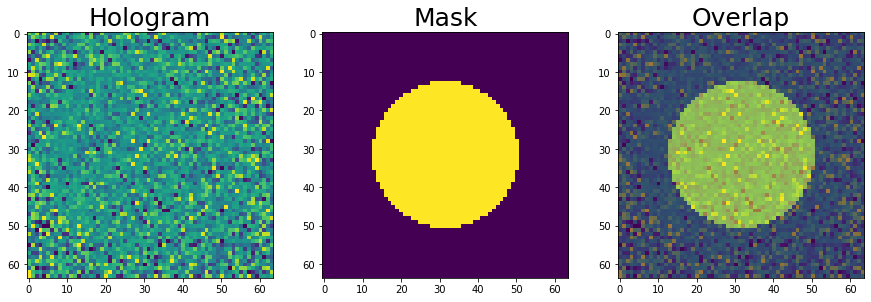

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.imshow(sample_data)
ax2.imshow(mask)

ax3.imshow(sample_data)
ax3.imshow(mask, alpha=0.5)

labels = ['Hologram', 'Mask', 'Overlap']

for i, lab in enumerate((ax1,ax2,ax3)):
    lab.set_title(labels[i], fontsize=25)

fig.savefig(dirpathimg + 'hologram_mask.png', bbox_inches='tight')

In [12]:
ds1 = np.array(ds1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [13]:
# list of exported data
for i in ds1:
    try: print(i[0])
    except: print([])

[]
0.00022700001770600137
False
b'AC'
0.41137695
2.2644043
18.902588


List validation

[ 0.411  0.152  0.623  1.4    2.814  0.042  0.088  0.167  1.333  0.095]

[b'AC' b'AC' b'AD' b'AE' b'AE' b'AF' b'AG' b'AH' b'AH' b'AI']

In [14]:
#validate to make sure the list is static
print(f'{np.arange(0,500000,50000)}\n{np.array(ds1[4])[[i for i in np.arange(0,500000,50000)]].round(3)}\n{np.array(ds1[3])[[i for i in np.arange(0,500000,50000)]]}')

[     0  50000 100000 150000 200000 250000 300000 350000 400000 450000]
[0.411 0.152 0.623 1.4   2.814 0.042 0.088 0.167 1.333 0.095]
[b'AC' b'AC' b'AD' b'AE' b'AE' b'AF' b'AG' b'AH' b'AH' b'AI']


In [15]:
# only one dataset type
idx = np.unique(ds1[3], return_index=True)
idx[0], set(ds1[3])

(array([b'AC', b'AD', b'AE', b'AF', b'AG', b'AH', b'AI', b'AJ', b'AK',
        b'AL'], dtype='|S2'),
 {b'AC', b'AD', b'AE', b'AF', b'AG', b'AH', b'AI', b'AJ', b'AK', b'AL'})

In [16]:
SESSION_LIST = np.unique(ds1[3]).tolist()
SESSION_LIST

[b'AC', b'AD', b'AE', b'AF', b'AG', b'AH', b'AI', b'AJ', b'AK', b'AL']

In [17]:
def normalize(dat):
    return (dat - dat.min()) / (dat.max() - dat.min())

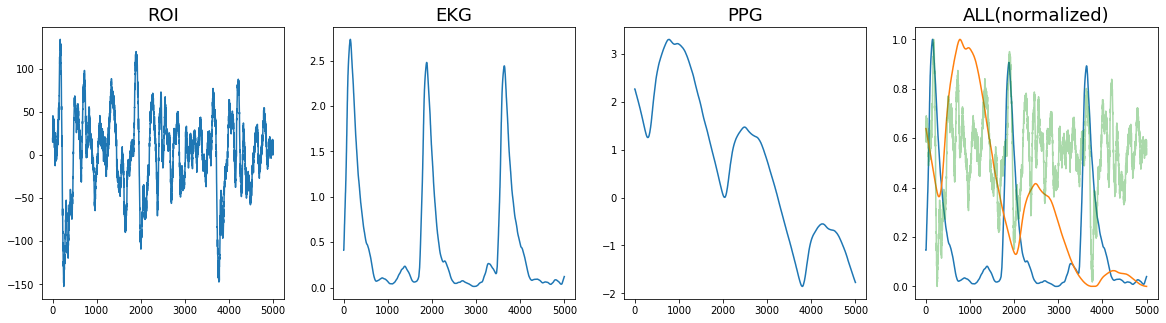

In [18]:
# ppg vs ekg
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))

nlim = 5000

ax1.plot((np.array(ds1[6]))[:nlim])
ax1.set_title('ROI', fontsize=18)
ax2.plot((np.array(ds1[4]))[:nlim])
ax2.set_title('EKG', fontsize=18)
ax3.plot((np.array(ds1[5]))[:nlim])
ax3.set_title('PPG', fontsize=18)

ax4.plot(normalize(np.array(ds1[4])[:nlim]))
ax4.plot(normalize(np.array(ds1[5])[:nlim])**2)
ax4.plot(normalize(np.array(ds1[6])[:nlim]), alpha=0.4)
# ax4.plot(normalize(np.array(ds1[6])[aq][:nlim])-normalize(np.array(ds1[4])[aq][:nlim]))
ax4.set_title('ALL(normalized)', fontsize=18)

plt.savefig(dirpathimg + 'overlap_original.png', bbox_inches='tight')

In [19]:
new_ds = np.array([])
new_ds = [[] for i in range(7)]

for i, dat in enumerate(ds1):
    new_ds[i] = np.array(dat)

In [20]:
# binarize boolean
new_ds[2] = new_ds[2] + 0
new_ds[2]

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
# data, time, stimulus, dataset, ekg, ppg
ds_by_session = [[] for i in range(10)]

for i, b_id in enumerate(SESSION_LIST):
    idx = new_ds[3] == b_id
    ds_by_session[i].append(new_ds[1][idx]) #time
    ds_by_session[i].append(new_ds[2][idx]) #stimulus
    ds_by_session[i].append(np.array([new_ds[6][idx], new_ds[4][idx], new_ds[5][idx]]).T) #ekg, ppg, hologram ROI

In [22]:
def check_discontinuity(data):
    '''input is a list of 0 and 1'''
    new_list = [[], []]
    temp = []
    for i in range(len(data)-1):
        temp.append(i)
        if data[i] != data[i+1]:
            new_list[data[i]].append(temp)
            temp = []
    if len(temp) != 0:
        new_list[data[temp[0]]].append(temp)
    return new_list

In [23]:
# raw/detrend plots
if False:
    for sess in range(10):

        t_i = np.arange(0,ds_by_session[sess][2][:,0].shape[0])
        t = ds_by_session[sess][1]

        fig, axs = plt.subplots(3,2, figsize=(14*2,7*3))

        for i in range(6):
            r = i%3
            c = i//3 
        
            if c == 0:
                axs[r,c].scatter(t_i[trim:-trim], ds_by_session[sess][2][:,r][trim:-trim], ls='-', marker='.', s=1, c=t[trim:-trim])
                axs[r,c].plot(t_i[trim:-trim], trends[sess][r][trim:-trim], 'r-')
            else:
                axs[r,c].scatter(t_i[trim:-trim], detrended_wave[sess][r][trim:-trim], ls='-', marker='.', s=1, c=t[trim:-trim])

        labels = ['hologram ROI', 'EKG', 'PPG']

        for i, lab in enumerate((ax1,ax2,ax3)):
            lab.set_title(labels[i], fontsize=25)

        fig.savefig(dirpathimg + f'vidualization/data_visualization_{sess}.png', bbox_inches='tight')

## Detrending

In [24]:
from scipy import signal
import statsmodels.api as sm
try:
    from obspy.signal.detrend import polynomial
except:
    %pip install obspy
    from obspy.signal.detrend import polynomial  

import warnings
warnings.simplefilter('ignore', np.RankWarning)  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [25]:
# fitting trends
from IPython.display import clear_output

trends = []

for sess in range(10):
    trends.append([])
    for i in range(3):
        data = ds_by_session[sess][2][:,i]
        x = np.arange(len(data))
        fit = np.polyval(np.polyfit(x, data, deg=15), x);
        trends[sess].append(fit)
        
clear_output()

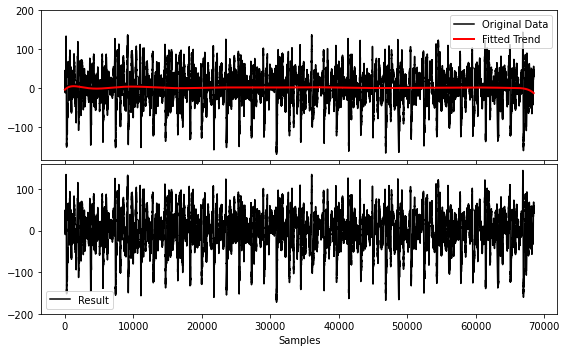

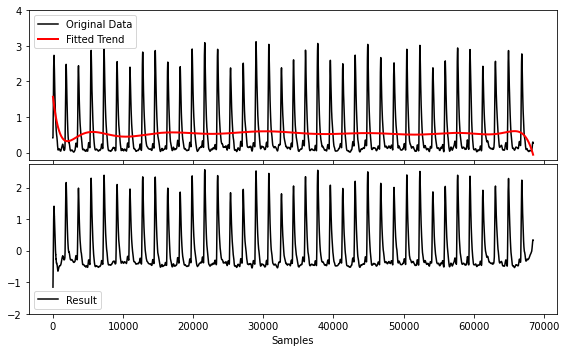

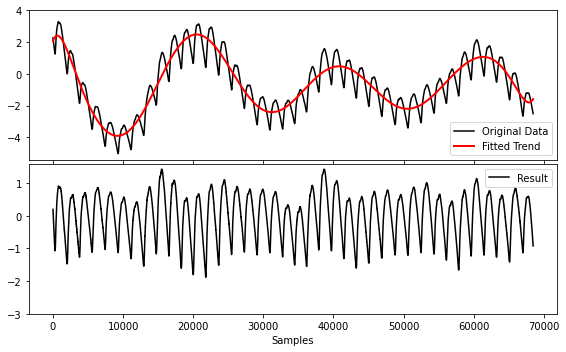

In [26]:
detrended_wave = []
plot = True

for sess in range(10):
    detrended_wave.append([])
    for i in range(3):
        ds_detrend_ppg = ds_by_session[sess][2][:,i].copy()
        if plot:
            detrended_wave[sess].append(polynomial(ds_detrend_ppg,15,plot=plot))            
        else:
            detrended_wave[sess].append(polynomial(ds_detrend_ppg,15,plot=plot))
    if plot: plot = False

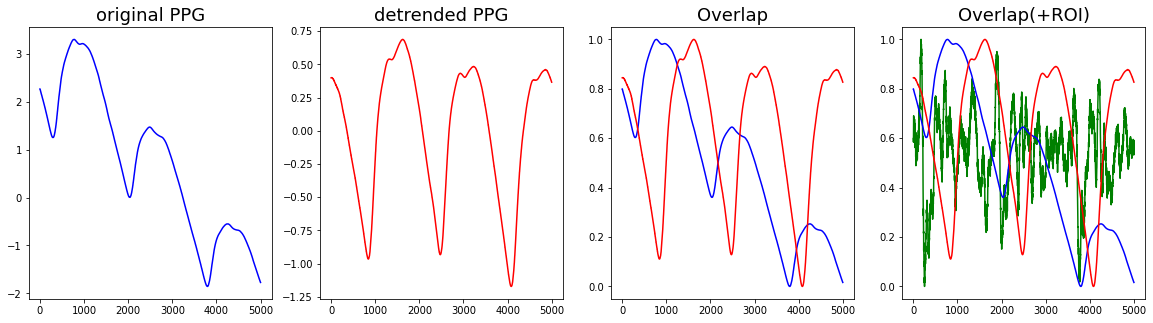

In [27]:
# ppg vs ekg (out of sync possibly due to the slanted nature of PPG waveform)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))

nlim = 5000
dsview = ds1

ax1.set_title('original PPG', fontsize=18)
ax1.plot((np.array(ds1[5]))[:nlim], 'b-')

ax2.set_title('detrended PPG', fontsize=18)
ax2.plot(ds_detrend_ppg[:nlim][::1], 'r-')

ax3.set_title('Overlap', fontsize=18)
ax3.plot(normalize(np.array(ds1[5])[:nlim]), 'b-')
ax3.plot(normalize(ds_detrend_ppg[:nlim][::1]), 'r-')

ax4.plot(normalize(np.array(ds1[6])[:nlim]),'g-')
ax4.plot(normalize(np.array(ds1[5])[:nlim]), 'b-')
ax4.plot(normalize(np.array(ds_detrend_ppg)[:nlim][::1]), 'r-', alpha=1.0)
ax4.set_title('Overlap(+ROI)', fontsize=18)

plt.savefig(dirpathimg + 'detrended.png', bbox_inches='tight')

In [28]:
#detrend the data
for j in range(3):
    for i in range(10):
        polynomial(ds_by_session[i][2][:,j],15);
clear_output()

## Binning and fast dcorr

In [29]:
#instantiate hyppo packages 
dcorr = hyppo.independence.Dcorr()
mgc   = hyppo.independence.MGC()
kmerf = hyppo.independence.KMERF()

In [30]:
for i in range(10):
    print(SESSION_LIST[i], ':', ds_by_session[i][0].shape[0])

b'AC' : 68469
b'AD' : 68623
b'AE' : 68557
b'AF' : 68233
b'AG' : 68237
b'AH' : 68553
b'AI' : 68612
b'AJ' : 68177
b'AK' : 68603
b'AL' : 68305


In [31]:
#size before binning
ds_by_session[0][0].shape

(68469,)

In [32]:
def binning(ds, k=10):
    '''follows ds_by_session structure
    ds = narray embedded in a list
    k = number of bins
    '''
    # new_ds = np.array([])
    new_ds = []
    st_lst = [] #new baseline vs stimulus binary

    for s in tqdm(range(len(ds))): #session
        new_ds.append([])
        st_lst.append([])

        for i in range(ds[s][2].shape[0]-k): #[time, stimulus, (roi, ekg, ppg)]
            st = np.unique(ds[s][1][i:i+k])
            if st.size == 1:
                st_lst[s].append(st[0])
                new_ds[s].append(ds[s][2][i:i+k].tolist())
                
    return new_ds, st_lst

In [33]:
#dcorr testing pipeline
dsetID = ['1027', '1130_s1', '1130_s3', '1112', '1118'][dataset]
bypass = False
results = []

# filename = dirpath2 + f'results_{dsetID}_dcorr_k={BIN_NUM}.pickle' #original
# filename = dirpath2 + f'results_{dsetID}_dcorr_k={BIN_NUM}_detrend_all.pickle' #detrended
filename = dirpath2 + f'results_{dsetID}_dcorr_k={BIN_NUM}_detrend_all_trim.pickle' #detrended and trimmed

if os.path.exists(filename) and bypass:
    with open(filename, 'rb') as f:
        results = pickle.load(f, encoding='bytes')
        print(f'[{filename}] LOADED')
else:    
    ds_by_session_bin, st_lst = binning(ds_by_session, k=BIN_NUM)

    for i in tqdm(range(10)):
        new_idx = np.arange(0,len(ds_by_session_bin[i]), 6) #choose every 6th
        new_x = np.array(ds_by_session_bin[i])[new_idx][trim:-trim]
        new_y = np.array(st_lst[i])[new_idx][trim:-trim]
        results.append([])
        new_wave = []
        for j in tqdm(range(3), leave=False):        
            results[i].append(dcorr.test(new_x[:,:,j],new_y, reps=0))
            # new_wave.append(normalize(new_x[:,:,j]))
        # r_e = new_wave[2] - new_wave[0]
        # r_p = new_wave[2] - new_wave[1]
        # r_ep = new_wave[2] - new_wave[1] - new_wave[0]
        # for k in tqdm([r_e, r_p, r_ep], leave=False):        
        #     results[i].append(dcorr.test(k,new_y, reps=0))

    with open(filename, 'wb') as f:
        pickle.dump(results, f)

## Statistical analysis
1. dcorr
2. t-test (1-sample, 2-sample)

In [35]:
# get rid of extremely low p-val
results2 = np.array(results)

for i, dat in enumerate(results2[:,:,1]):
    results2[:,:,1][i][dat < 0.0001] = 0.0001

In [36]:
match1 = np.where(results2[:,0,1] < 0.001)[0]
match2 = np.where(results2[:,1,1] < 0.001)[0]

In [37]:
df_match = pd.DataFrame(np.vstack([results2[match1][:,:,1], results2[match2][:,:,1]]), columns=['ROI', 'EKG', 'PPG'])
df_match.index = ['Session(ROI) #' + str(i) for i in match1] + ['Session(EKG) #' + str(i) for i in match2]
df_match

,ROI,EKG,PPG
Session(ROI) #2,0.000100,0.000100,0.000100
Session(ROI) #4,0.000100,0.028997,0.000225
Session(ROI) #5,0.000928,0.000100,0.000100
Session(EKG) #2,0.000100,0.000100,0.000100
Session(EKG) #3,0.099063,0.000933,0.000100
Session(EKG) #5,0.000928,0.000100,0.000100
Session(EKG) #7,0.089177,0.000100,0.000100


In [38]:
match3 = np.intersect1d(match1, match2)
df_match = pd.DataFrame(results2[match3][:,:,1], columns=['ROI', 'EKG', 'PPG'])
df_match.index = ['Session(BOTH) #' + str(i) for i in match3]
df_match

,ROI,EKG,PPG
Session(BOTH) #2,0.000100,0.0001,0.0001
Session(BOTH) #5,0.000928,0.0001,0.0001


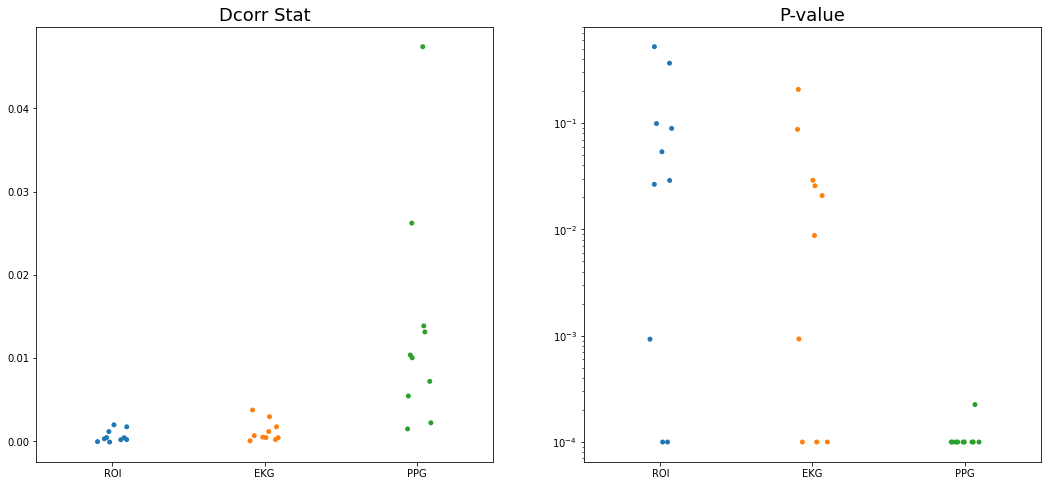

In [39]:
f = plt.figure(figsize=(6*3,4*2))
col = ['ROI', 'EKG', 'PPG', 'ROI-EKG', 'ROI-PPG', 'ROI-EKG-PPG']

gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
ax.set_title('Dcorr Stat', fontsize=18)
sns.stripplot(data=pd.DataFrame(np.array(results2)[:,:3,0],columns=col[:3])) #first three columns

ax = f.add_subplot(gs[0, 1])
ax.set_title('P-value', fontsize=18)
plt.yscale('log')
sns.stripplot(data=pd.DataFrame(np.array(results2)[:,:3,1],columns=col[:3]))

plt.savefig('new_bin_dcorr_plot.png', bbox_inches='tight')

In [40]:
# concatenate X and y for pairplot
newX, newY = [], []
ds_by_session_bin, st_lst = binning(ds_by_session, k=BIN_NUM)

for i in tqdm(range(10)):
    
    newX.append([])
    newY.append([])
    
    new_idx = np.arange(0,len(ds_by_session_bin[i]), 6) #choose every 6th
    new_x = np.array(ds_by_session_bin[i])[new_idx]
    new_y = np.array(st_lst[i])[new_idx]
    
    newX[i] = new_x
    newY[i] = new_y

ds_by_session_bin_detrend = ds_by_session_bin.copy()

List Validation

23.042, 40.836, -92.794, 15.993

In [41]:
print(f'{newX[0][0][0][0].round(3)}, {newX[3][0][0][0].round(3)}, {newX[5][0][0][0].round(3)}, {newX[7][0][0][0].round(3)}')

23.042, 40.836, -92.794, 15.993


In [42]:
# plotting seaborn pairplot
if False:
    col = [f'Column #{i+1}' for i in range(10)] + ['Labels']
    for j, char in enumerate(tqdm(['ROI', 'EKG', 'PPG'])):
        for i in tqdm(range(10),leave=False):
            fname = dirpathimg + f'pairplot/pairplot_{char}_{i}.png'
            if os.path.exists(fname):
                pass
            else:
                fig, ax = plt.subplots(1,1)
                ax = sns.set(rc={'axes.facecolor':'cornflowerblue', 'axes.grid':'False'});#, 'figure.facecolor':'cornflowerblue'
                ax = sns.pairplot(pd.DataFrame(np.column_stack([newX[i][:,:,j], newY[i]]), columns=col), hue='Labels', palette=['purple','yellow'])
                plt.savefig(fname, bbox_inches='tight')
                
                plt.cla() # Clear the current axes
                plt.clf() # Clear the current figure
                plt.close('all')   
                plt.close(fig)
                gc.collect()

In [43]:
# mean variance table
col = [f'Column #{i+1}' for i in range(10)] + ['Labels']
col_m = ['ROI(0)', 'ROI(1)','EKG(0)', 'EKG(1)','PPG(0)', 'PPG(1)']
col = ['Value', 'Labels']

df_mean = pd.DataFrame(columns=col_m)

def check_neg(num):
    if num < 0:
        return f'({num})'
    return num

for i in range(10):
    temp = [[]]
    for j in range(3):
        temp_df = pd.DataFrame(np.column_stack([newX[i][:,:,j].mean(axis=1), newY[i]]), columns=col).groupby('Labels')
        mu = round(temp_df.mean(),2)
        sig = round(temp_df.var(),2)
        temp[0].append(f'u={check_neg(mu.iloc[0][0])}, s={check_neg(sig.iloc[0][0])}')
        temp[0].append(f'u={check_neg(mu.iloc[1][0])}, s={check_neg(sig.iloc[1][0])}')
    df_mean = df_mean.append(pd.DataFrame(np.array(temp), columns=col_m, index=[f'session(trial) #{i+1}']))

df_mean

,ROI(0),ROI(1),EKG(0),EKG(1),PPG(0),PPG(1)
session(trial) #1,"u=0.6, s=2078.31","u=(-0.68), s=2182.2","u=0.0, s=0.51","u=-0.0, s=0.53","u=0.05, s=0.49","u=(-0.06), s=0.48"
session(trial) #2,"u=0.47, s=2645.64","u=(-0.45), s=2355.34","u=0.0, s=0.53","u=-0.0, s=0.55","u=(-0.03), s=0.49","u=0.03, s=0.53"
session(trial) #3,"u=0.31, s=2792.84","u=(-0.36), s=2414.69","u=(-0.01), s=0.54","u=0.01, s=0.56","u=0.03, s=0.47","u=(-0.03), s=0.52"
session(trial) #4,"u=(-0.38), s=2763.24","u=0.4, s=2728.02","u=(-0.02), s=0.51","u=0.02, s=0.59","u=0.05, s=0.41","u=(-0.05), s=0.4"
session(trial) #5,"u=0.62, s=2506.15","u=(-0.69), s=2980.8","u=0.0, s=0.56","u=0.0, s=0.58","u=0.02, s=0.42","u=(-0.02), s=0.42"
session(trial) #6,"u=1.91, s=2635.24","u=(-1.76), s=2836.31","u=(-0.02), s=0.57","u=0.02, s=0.58","u=0.02, s=0.29","u=(-0.02), s=0.32"
session(trial) #7,"u=(-0.5), s=2837.13","u=0.49, s=2884.86","u=-0.0, s=0.58","u=0.0, s=0.58","u=0.01, s=0.31","u=(-0.01), s=0.33"
session(trial) #8,"u=0.09, s=2797.76","u=(-0.05), s=2825.97","u=0.03, s=0.62","u=(-0.03), s=0.58","u=(-0.03), s=0.27","u=0.04, s=0.27"
session(trial) #9,"u=(-0.32), s=2980.48","u=0.34, s=2989.46","u=0.0, s=0.59","u=-0.0, s=0.58","u=0.07, s=0.32","u=(-0.08), s=0.28"
session(trial) #10,"u=(-0.03), s=2708.16","u=(-0.03), s=2696.41","u=(-0.01), s=0.55","u=0.01, s=0.58","u=0.09, s=0.3","u=(-0.1), s=0.29"


In [44]:
from scipy import stats

In [59]:
# 1-sample t-test, two-sided (u(1) > u(0))
ttest1 = []

for j, sess in enumerate(match1): #match1 => ROI dcorr p-value
    ttest1.append([])
    for i in range(3):
        
        xbar = newX[sess][newY[sess] == 0][:,:,i]
        xbar = xbar.flatten().mean()
        y = stats.ttest_1samp(newX[sess][newY[sess] == 1][:,:,i].flatten(), xbar)[1] #p-value
        ttest1[j].append(y)        

In [77]:
df_1sample = pd.DataFrame(np.array(ttest1)[:,0], columns=['P-value(ROI)'])
df_1sample.index = [f'Session #{i}' for i in match1]
df_1sample

,P-value(ROI)
Session #2,1.353356e-03
Session #4,2.826489e-08
Session #5,3.987610e-62


In [68]:
# 2-sample t-test, one-sided (u(1) > u(0))
ttest2 = []

for j, sess in enumerate(match1): #match1 => ROI dcorr p-value
    ttest2.append([])
    for i in range(3):
        
        x_base = newX[sess][newY[sess] == 0][:,:,i].flatten()
        x_stim = newX[sess][newY[sess] == 1][:,:,i].flatten()
        y = stats.ttest_ind(x_base, x_stim, equal_var=False)[1] #2 sample unpaired 2 sided
        ttest2[j].append(y/2) # making 1-sided

In [69]:
# ttest2
df_2sample = pd.DataFrame(np.array(ttest2)[:,0], columns=['P-value(ROI)'])
df_2sample.index = [f'Session #{i}' for i in match1]
df_2sample

,P-value(ROI)
Session #2,1.393563e-02
Session #4,1.442548e-05
Session #5,2.684150e-32


In [75]:
df_sample = np.hstack([df_1sample, df_2sample])
df_sample = pd.DataFrame(df_sample, columns=['P-value(ROI; 1-sample)', 'P-value(ROI; 2-sample)'])
df_sample.index = [f'Session #{i}' for i in match1]
df_sample

,P-value(ROI; 1-sample),P-value(ROI; 2-sample)
Session #2,1.353356e-03,1.393563e-02
Session #4,2.826489e-08,1.442548e-05
Session #5,3.987610e-62,2.684150e-32


In [51]:
#violin plots and strip plots
col = ['Value', 'Labels']

if False:
    for k,_ in enumerate(['Violin', 'Strip']):
        for j, dat in enumerate(['ROI', 'EKG', 'PPG']):
            f = plt.figure(figsize=(6*5,6*2))
            gs = f.add_gridspec(2,5)

            for i in range(10):
                rs=i//5
                cs=i%5
                ax = f.add_subplot(gs[rs,cs])
                # f.suptitle(f'{dat}')
                ax.set_title(f'Session{i+1}({dat})')      
                tempx = pd.DataFrame(np.column_stack([newX[i][:,:,j].flatten(), newY[i].repeat(10)]), columns=col)  
                # tempx = pd.DataFrame(np.column_stack([newX[i][:,:,j].mean(axis=1), newY[i]]), columns=col)
                if k == 0:
                    sns.violinplot(x='Labels', data=tempx, y='Value', orient='v', palette=['purple','yellow'])
                else:
                    sns.stripplot(x='Labels', y='Value', data=tempx, hue='Labels', palette=['purple','yellow'])                   
                    
                ax.legend([])

            if k == 0:
                plt.savefig(dirpathimg + f'violin/violinplot_{dat}.png', bbox_inches='tight')
            else:
                plt.savefig(dirpathimg + f'strip/stripplot_{dat}.png', bbox_inches='tight')
            
            plt.cla() # Clear the current axes
            plt.clf() # Clear the current figure
            plt.close('all')   
            plt.close(fig)
            gc.collect()    

## Pairwise distance heatmap plotting

In [52]:
from sklearn.metrics import pairwise_distances

In [53]:
metric = 'euclidean'
x = np.array(ds_by_session_bin[1])[:,:,1]

In [54]:
idx_lst = np.cumsum([0] + [round(x.shape[0]/6) for i in range(6)])
idx_lst, x.shape[0]

(array([    0, 11420, 22840, 34260, 45680, 57100, 68520]), 68523)

In [55]:
# pairwise distance heatmap
if False:
    n = idx_lst.shape[0]
    sess_num = 1

    dtype = ['ROI', 'EKG', 'PPG']

    # plt.style.use('ggplot')
    sns.set(rc={'axes.grid':'False'});

    for iii, dt in enumerate(tqdm(dtype)):

        x = np.array(ds_by_session_bin[sess_num])[:,:,iii]

        for ii, i in enumerate(tqdm(range(n-1), leave=False)):

            # if ii < 4:
            fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
            i_0 = idx_lst[i]
            i_1 = idx_lst[i+1]
            # fig.add_subplot(5,2,ii+1)
            distx = pairwise_distances(x[i_0:i_1], metric=metric)
            mlp = ax1.imshow(distx)
            fig.colorbar(mlp, ax=ax1)
            del distx

            y = np.array(st_lst[sess_num])[i_0:i_1]
            ax2.plot(np.arange(0,y.shape[0]), y)
            filename = dirpathimg + f'heatmap/heatmap_{dt}_{ii}'
            plt.savefig(filename, bbox_inches='tight')
            
            plt.cla() # Clear the current axes
            plt.clf() # Clear the current figure
            plt.close('all')   
            plt.close(fig)
            gc.collect()